In [2]:
# Here we'll have a look at the different types of analyzes
# that the sepal package enables. In order to do this
# we will make use of the melanoma sample used in the paper

In [3]:
# Imports
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sepal
import sepal.datasets as d
import sepal.models as m
import sepal.utils as ut
import sepal.family as family
import sepal.enrich as fea


In [4]:
# Set path to melanoma sample
pth = "../data/real/melanoma.tsv.gz"
# load in the raw data using the RawData class
raw_data = d.RawData(pth,)
# filter genes observed in less than 5 spots
# and/or less than 10 total observations

raw_data.cnt = ut.filter_genes(raw_data.cnt,
                               min_expr=10,
                               min_occur=5)
# load into our our count data object
# this is a ST1K array, hence
# we use the ST1K class

data = m.ST1K(raw_data,
              eps = 0.1)

In [5]:
# We will normalize our count data
# and then propagate it in time, to measure
# the diffusion time.
# We set scale = True to perform
# minmax scaling of the diffusion times

# Running the simulation on 8 cores
# takes about ~2 minutes
times = m.propagate(data,
                    normalize = True,
                    scale =True)

  0%|          | 0/9956 [00:00<?, ?it/s]

[INFO] : Using 8 workers
[INFO] : Saturated Spots : 203


100%|██████████| 9956/9956 [01:04<00:00, 153.44it/s]


In [6]:
# Now, once the diffusion times
# have been computed for all the 
# profiles, we can inspect the
# top 20 highest ranked ones

n_top = 20
# get names of profiles
sorted_indices = np.argsort(times.values.flatten())
# argsort sorts from low to high, so reverse the order
sorted_indices = sorted_indices[::-1]
sorted_profiles = times.index.values[sorted_indices]
# extract top profiles
top_profiles = sorted_profiles[0:n_top]
# display top profiles and their times
times.loc[top_profiles,:]

average
RNASET2  1.000000
MLANA    0.836610
BCAN     0.765424
DOK5     0.739661
COL1A1   0.729492
MCAM     0.724068
MCOLN3   0.686102
RIPK4    0.684068
PMEL     0.671186
RGS5     0.596610
FCRL1    0.595932
FMN1     0.593898
COL3A1   0.578983
MZB1     0.541695
GPM6B    0.536949
IGFBP7   0.532881
VAV2     0.522712
CTSF     0.519322
CORO1A   0.517966
TTC8     0.512542

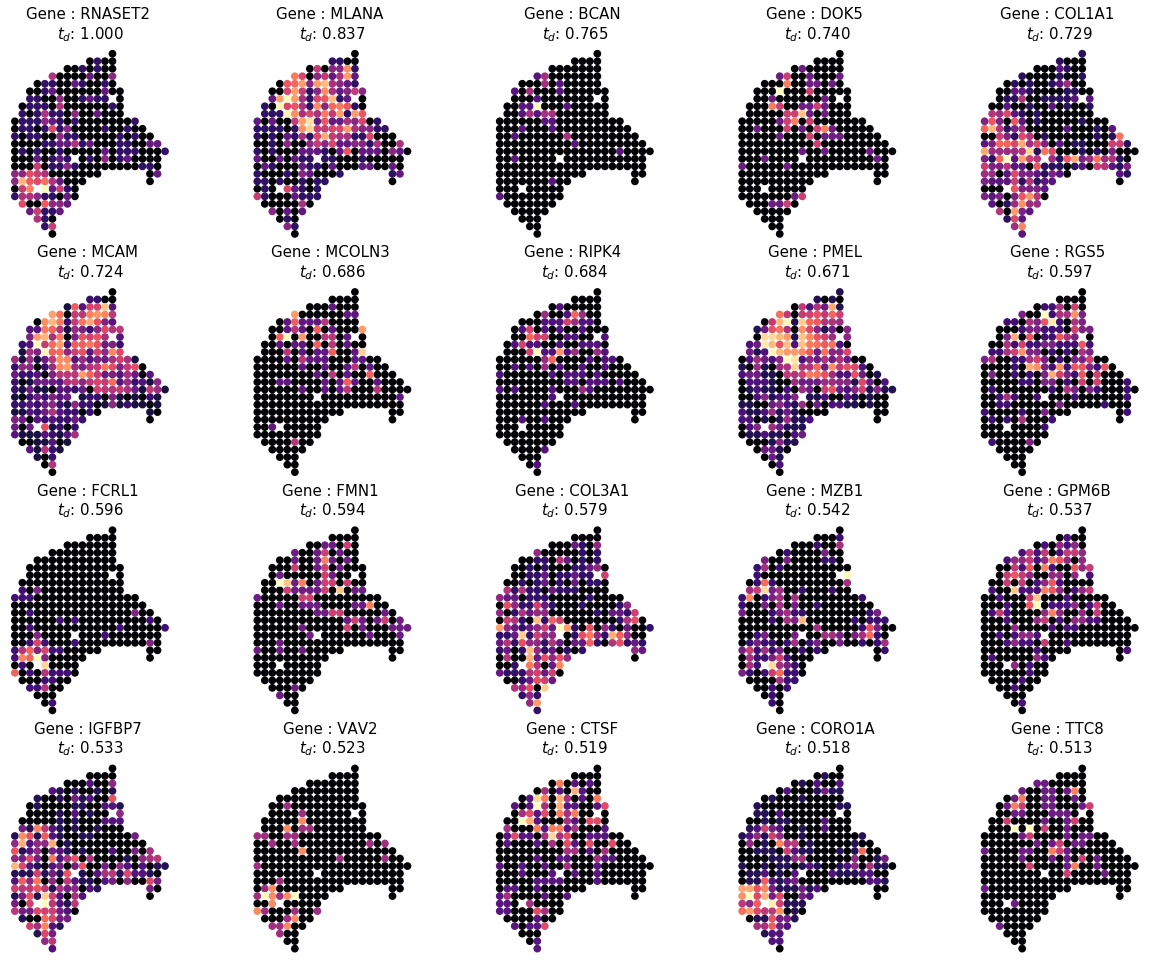

In [7]:
# Now, let us also inspect these visually
# for this we can use the "plot_profiles"
# function for this purpose


# specifications for our 
# plot. Same syntac
# as the scatter function
# in matplotlib

pltargs = dict(s = 60,
                cmap = "magma",
                edgecolor = 'none',
                marker = 'o',
                )

# plot the profiles
fig,ax = ut.plot_profiles(cnt = data.cnt.loc[:,top_profiles],
                          crd = data.real_crd,
                          rank_values = times.loc[top_profiles,:].values.flatten(),
                          pltargs = pltargs,
                         )
plt.show()

In [12]:
# Let us, as a subsequent step, sort
# these profiles into pattern families

# we will use the top 100 profiles
# to build our families
n_build = 150

# use the "get_families" function
# to group the profiles
family_labels,repr_patterns = family.get_families(data.cnt.loc[:,sorted_profiles].values,
                                            n_base = n_build,
                                            n_sort = n_build,
                                            threshold = 0.80,
                                            )
# familiy label is am array of family indices
# for each of the profiles. We convert
# this to a data frame to make it easier to work with
families = pd.DataFrame(family_labels,
                        index = sorted_profiles[0:n_build],
                        columns = ['family'],
                        )



[INFO] : Using 4 eigenpatterns
[INFO] : Identified 4 families


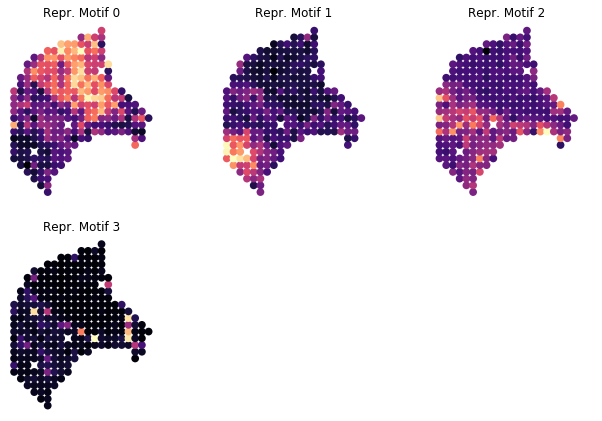

In [13]:
# As displayed, 4 families were found. To get
# an idea of what type what type of spatial
# patterns that each family consists of
# we will plot their respective representative motifs

# use the "plot_representative" function
# for this purpose
fig, ax = family.plot_representative(motifs=repr_patterns,
                                 crd = data.real_crd,
                                 ncols = 3,
                                 pltargs=pltargs)

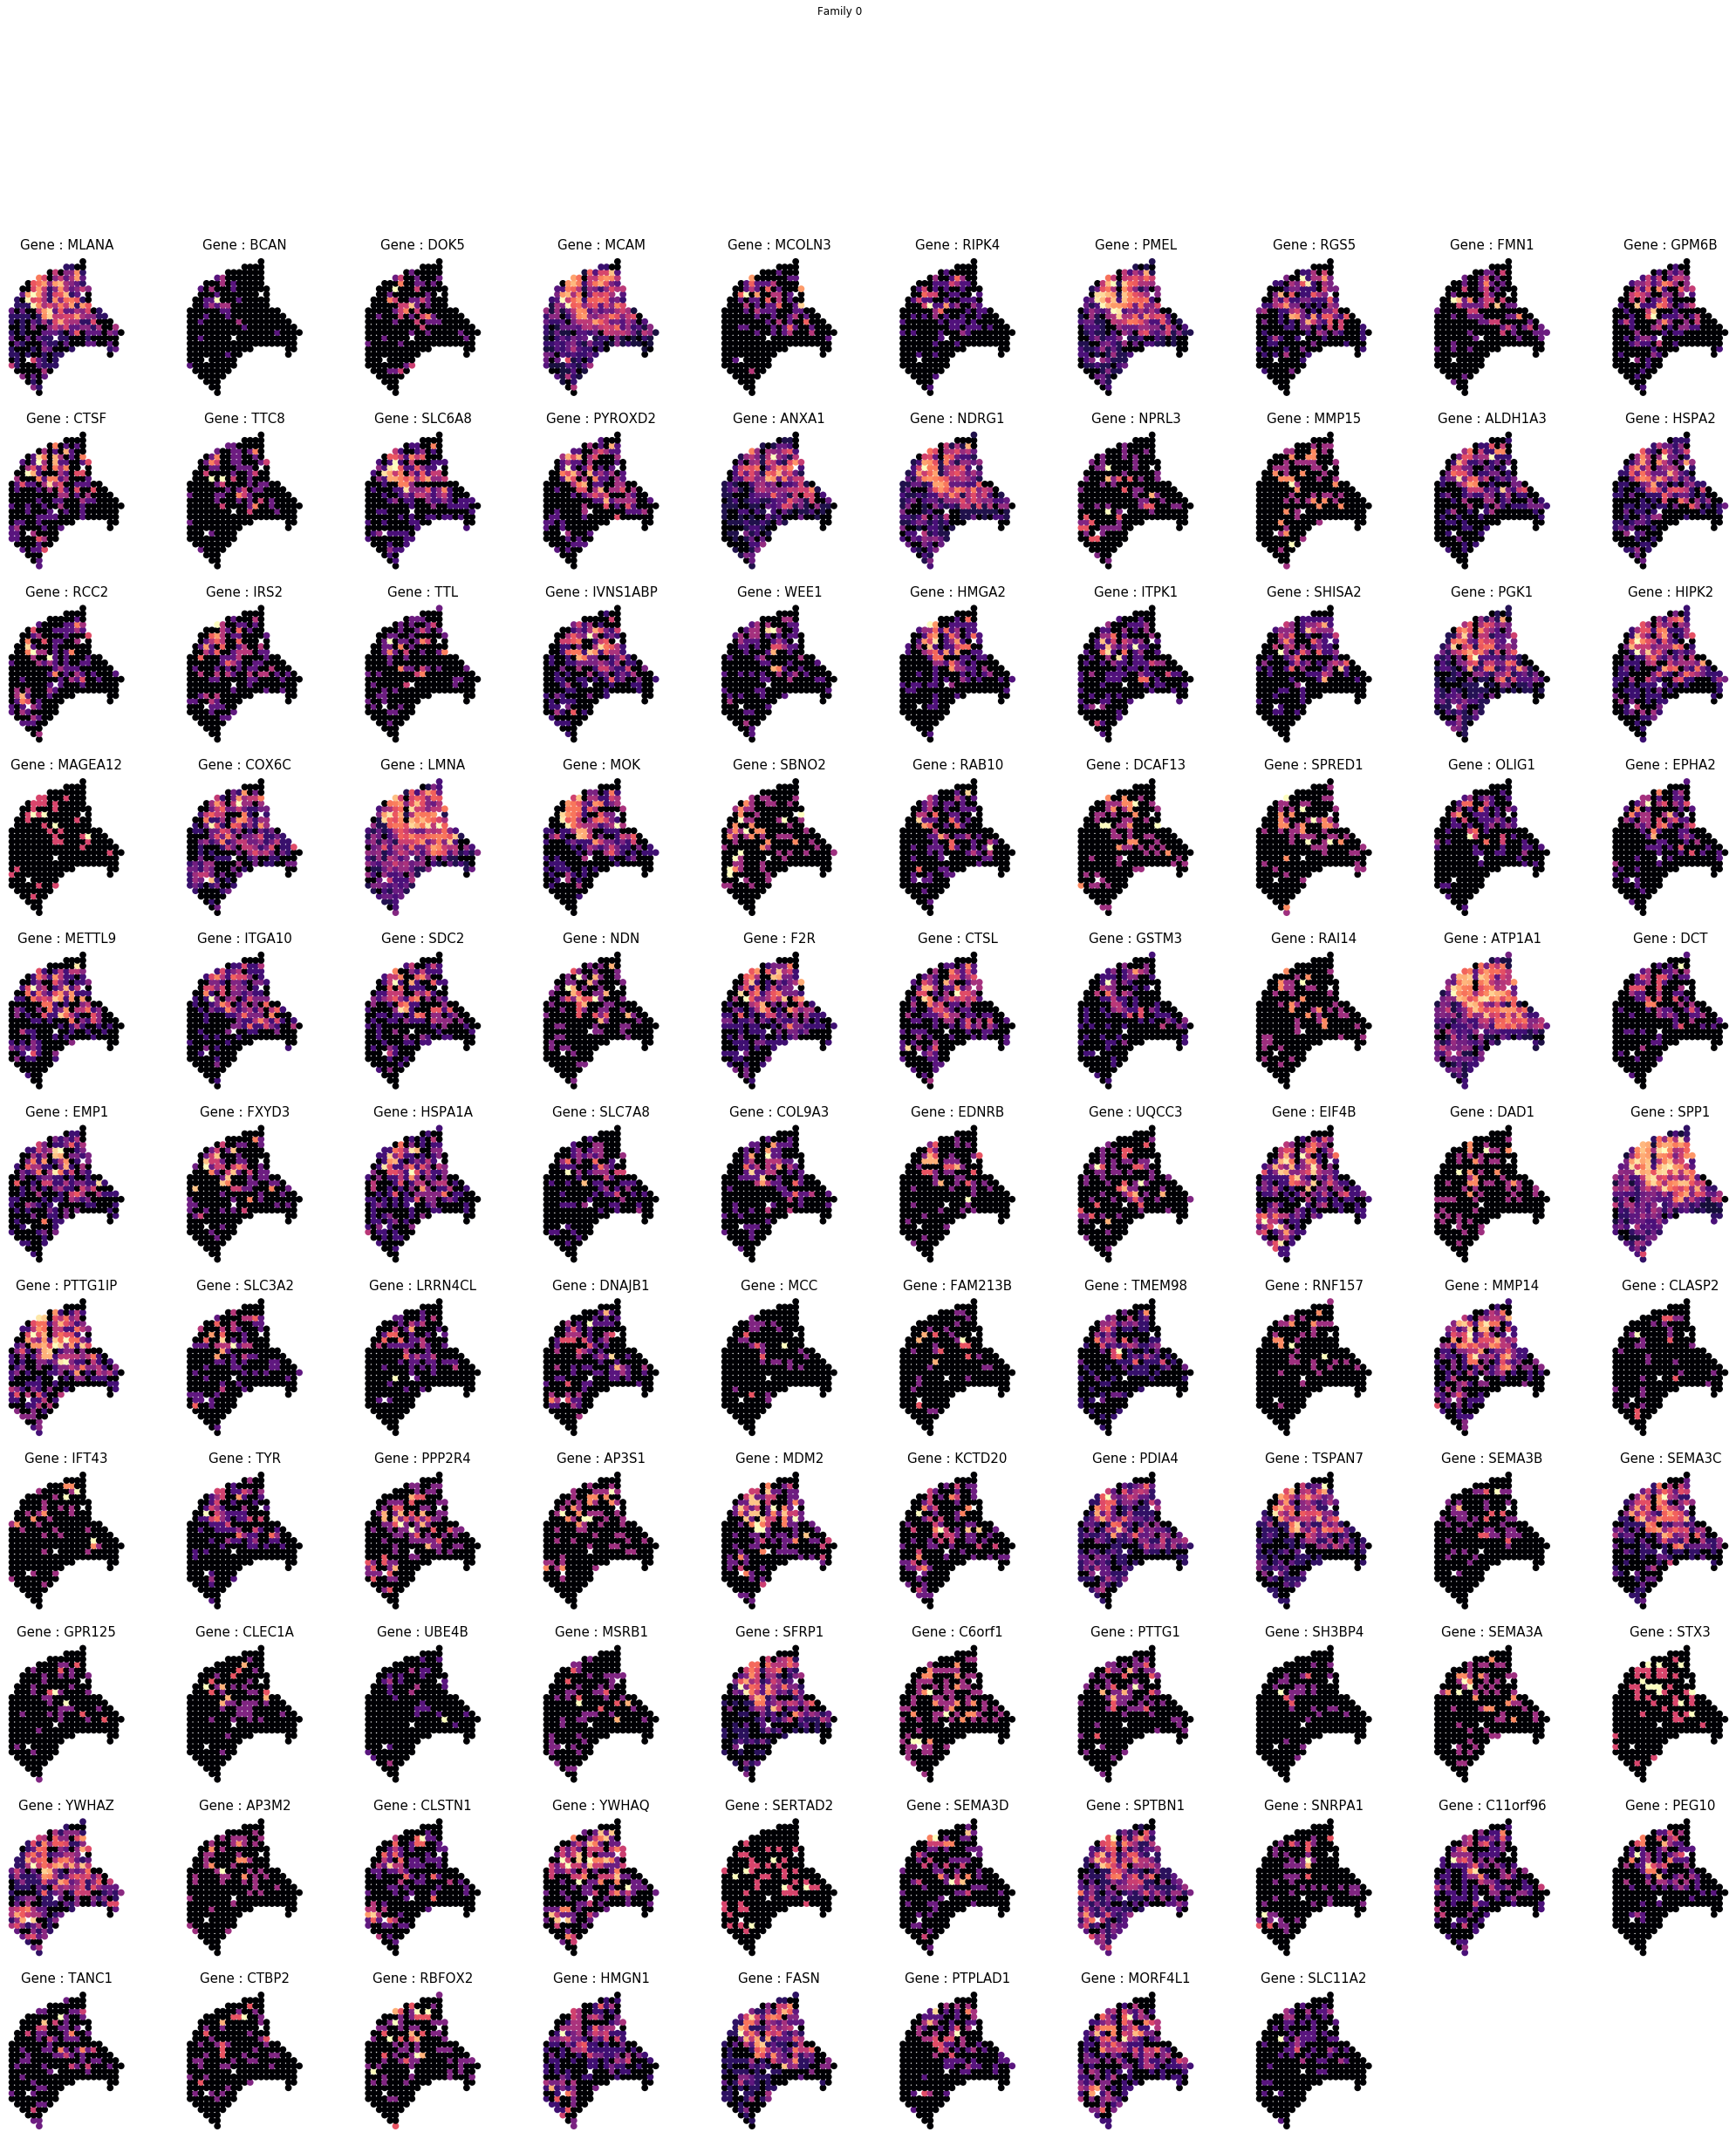

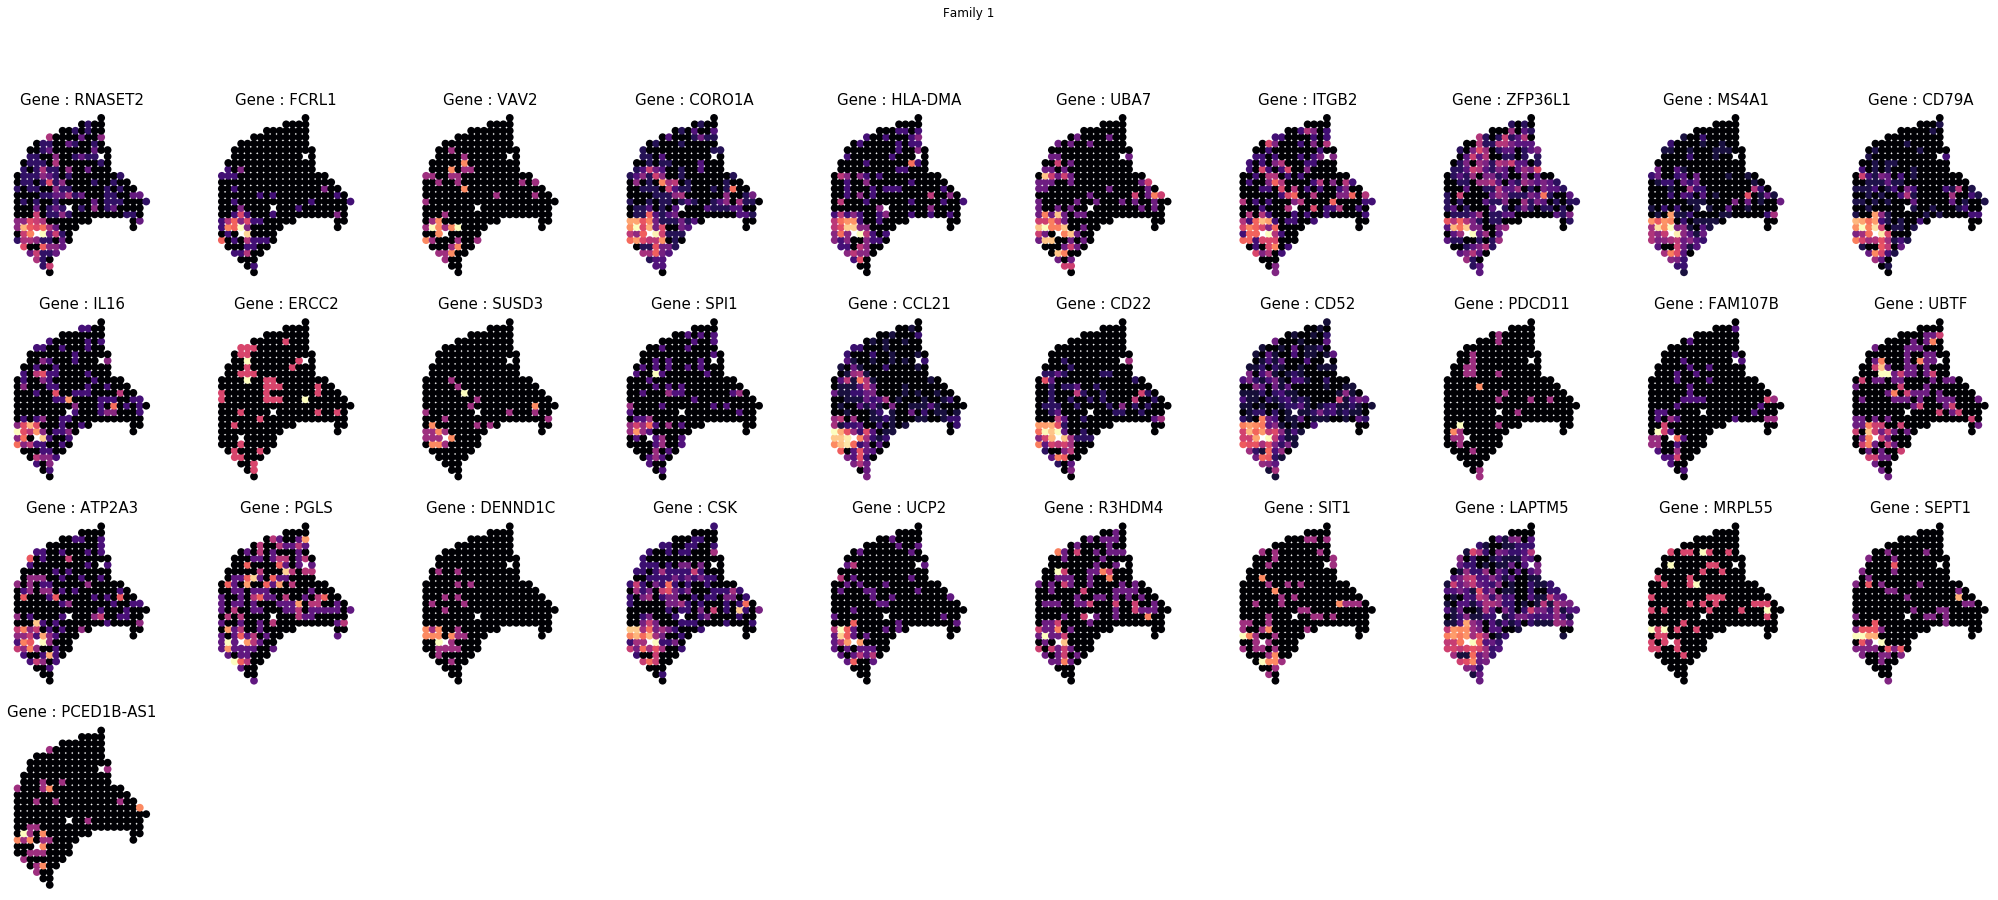

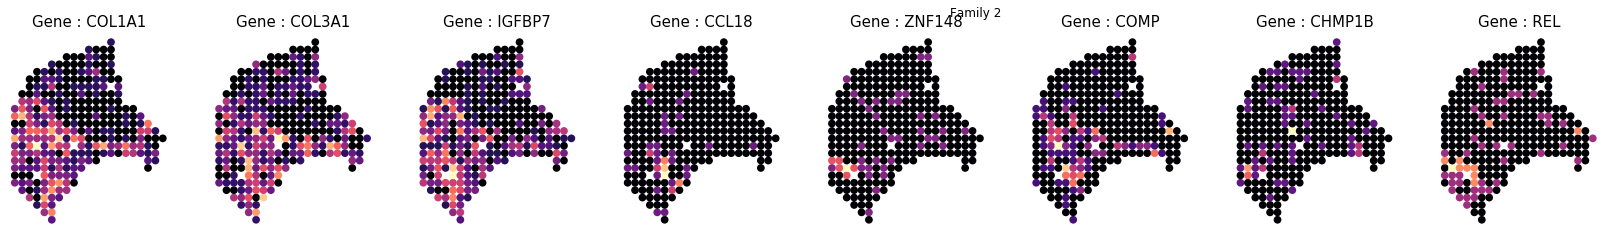

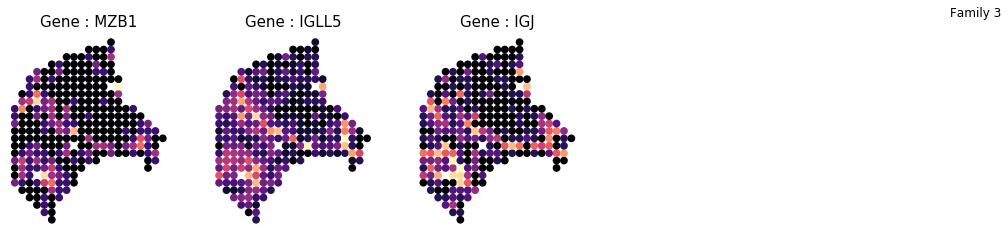

In [14]:
# having done so, we se that the motifs differ to some extent
# and we may inspect all the members of each
# family

# use the "plot_family" function for this
family_plots= family.plot_families(data.cnt.loc[:,sorted_profiles[0:n_build]].values,
                           genes = sorted_profiles[0:n_build],
                           crd = data.real_crd,
                           labels = family_labels,
                           ncols = 10,
                           pltargs = pltargs,
                           side_size = 300,
                           )


In [15]:
# Finally, to see what drives the spatial
# patterns associated to each motif
# we can subject the
# families to an enrichment analysis

# to analyze a the families we have found
# simply use the output of data frame
# generated from the "get_families" output
# as input to "analyze_families"

# we will query against GO:BP
# and use human as organism
# we use g:Profiler as a backend in our
# enrichment analysis


fea_res = fea.analyze_families(families,
                       organism = "hsapiens",
                       dbs = ["GO:BP"],
                       )


In [16]:
# The identified processes, with a significant
# enrichment are
fea_res

family      native                                               name  \
1        0  GO:0007399                         nervous system development   
2        0  GO:0022008                                       neurogenesis   
3        0  GO:0032502                              developmental process   
4        0  GO:0048856                   anatomical structure development   
5        0  GO:0048699                              generation of neurons   
..     ...         ...                                                ...   
75       1  GO:0002684       positive regulation of immune system process   
76       2  GO:0030199                       collagen fibril organization   
77       2  GO:0030168                                platelet activation   
78       3  GO:0002640  regulation of immunoglobulin biosynthetic process   
79       3  GO:0002642  positive regulation of immunoglobulin biosynth...   

         p_value source  intersection_size  
1   5.877865e-08  GO:BP                 40  
2   6.382998e-08  GO:BP                 33  
3   6.629987e-08  GO:BP                 69  
4   2.332163e-07  GO:BP                 65  
5   1.409125e-06  GO:BP                 30  
..           ...    ...                ...  
75  4.670279e-02  GO:BP                  9  
76  1.654811e-03  GO:BP                  3  
77  4.127980e-02  GO:BP                  3  
78  4.986357e-02  GO:BP                  1  
79  4.986357e-02  GO:BP                  1  

[79 rows x 6 columns]